# 5. Train, test and validate GNN Model
### 5.1 Setup instructions
Before training and testing the model, ensure that the dataset exists at the specified path mentioned in the notebook.
Import the necessary modules and packages:

In [8]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset_path = "datasets/data.pt"
dataset_validate_path = "datasets/data_validate.pt"

data = torch.load(dataset_path)

### 5.2 Define the GCN model
The graph convolutional operator from the [“Semi-supervised Classification with Graph Convolutional Networks”](https://arxiv.org/abs/1609.02907 paper
$$
\mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},
$$
where $\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$ denotes the adjacency matrix with inserted self-loops and $\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}$ its diagonal degree matrix. The adjacency matrix can include other values than 1 representing edge weights via the optional edge_weight tensor.

Its node-wise formulation is given by:
$$
\mathbf{x}^{\prime}_i = \mathbf{\Theta}^{\top} \sum_{j \in
\mathcal{N}(i) \cup \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j
\hat{d}_i}} \mathbf{x}_j
$$
with $\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}$, where $e_{j,i}$ denotes the edge weight from source node `j` to target node `i (default: 1.0)

This GCN implementation from PyTorch Geometric is utilized to construct the graph. The GCN model is defined with a specified number of layers and neurons per layer. The model is trained using the Adam optimizer with given learning rate and weight decay values. The training function is defined below. We will construct our graph object using this class and passing the following attributes, noting that all arguments are torch tensors.
- `num_features`: the number of features for each node.
- `num_classes`: the number of classes for the classification task.
- `num_neurons`: the number of neurons per layer.
- `network_size`: the number of layers.

When training the model, we will pass in the `data` object, which contains the following attributes:
- `x`: will be assigned to the encoded node features, its shape is [number_of_nodes, number_of_features].
- `y`: will be assigned to the node labels, its shape is [number_of_nodes]
- `edge_index`: will be assigned to the edge indices, its shape is [2, number_of_edges].
- `edge_attr`: will be assigned to the edge attributes, which in this case is the edge weight, its shape is [number_of_edges, number_of_edge_features].

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_neurons, network_size):
        super(GCN, self).__init__()

        self.conv_layers = torch.nn.ModuleList()
        self.conv_layers.append(GCNConv(num_features, num_neurons))
        for _ in range(network_size - 1):
            self.conv_layers.append(GCNConv(num_neurons, num_neurons))
        self.conv_layers.append(GCNConv(num_neurons, num_classes))

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        for i, conv_layer in enumerate(self.conv_layers):
            if i != len(self.conv_layers) - 1:
                x = F.relu(conv_layer(x, edge_index, edge_weight))
            else:
                x = conv_layer(x, edge_index, edge_weight)

        return F.log_softmax(x, dim=1)


        # for conv in self.conv_layers[:-1]:
        #     x = conv(x, edge_index)
        #     x = x.relu()
        #
        # x = self.conv_layers[-1](x, edge_index)
        #
        # return x.log_softmax(dim=1)


### 5.3 Define model parameters and train
Once the setup is complete, it is necessary to define the model parameters and initiate the training process. The hyperparameter values determined during the hyperparameter tuning stage are used for training the model.

In [10]:
num_neurons = 128
network_size = 4
lr = 0.019474
weight_decay = 0.0000035147


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data.num_node_features, int(data.y.max() + 2), num_neurons, network_size).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [21]:
# Initialize lists to store loss and accuracy values
loss_values = []
test_accs = []
train_accs = []

model.train()
best_model_state = model.state_dict()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())


    train_correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    train_acc = int(train_correct) / int(data.train_mask.sum())

    print("Epoch: " + str(epoch))
    print(f'Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {acc:.4f}')

    loss_values.append(loss.item())
    test_accs.append(acc)
    train_accs.append(train_acc)

    if acc > max(test_accs):
        best_model_state = model.state_dict()

Epoch: 0
Loss: 0.3974, Train Accuracy: 0.8126, Test Accuracy: 0.8063
Epoch: 1
Loss: 0.4047, Train Accuracy: 0.8148, Test Accuracy: 0.8187
Epoch: 2
Loss: 0.4084, Train Accuracy: 0.8239, Test Accuracy: 0.8187
Epoch: 3
Loss: 0.3912, Train Accuracy: 0.8098, Test Accuracy: 0.8025
Epoch: 4
Loss: 0.4040, Train Accuracy: 0.8195, Test Accuracy: 0.8200
Epoch: 5
Loss: 0.4035, Train Accuracy: 0.8252, Test Accuracy: 0.8150
Epoch: 6
Loss: 0.3884, Train Accuracy: 0.8139, Test Accuracy: 0.8137
Epoch: 7
Loss: 0.3967, Train Accuracy: 0.8211, Test Accuracy: 0.8250
Epoch: 8
Loss: 0.4018, Train Accuracy: 0.8198, Test Accuracy: 0.8187
Epoch: 9
Loss: 0.3891, Train Accuracy: 0.8246, Test Accuracy: 0.8213
Epoch: 10
Loss: 0.3868, Train Accuracy: 0.8220, Test Accuracy: 0.8275
Epoch: 11
Loss: 0.3954, Train Accuracy: 0.8139, Test Accuracy: 0.8063
Epoch: 12
Loss: 0.3945, Train Accuracy: 0.8283, Test Accuracy: 0.8237
Epoch: 13
Loss: 0.3859, Train Accuracy: 0.8277, Test Accuracy: 0.8263
Epoch: 14
Loss: 0.3830, Train 

The loss, train accuracy, and test accuracy are printed for each epoch and are stored in lists for visualization and analysis.

After the training loop, the loss graph and test/train accuracy graph are plotted to visualize the training progress and model performance:

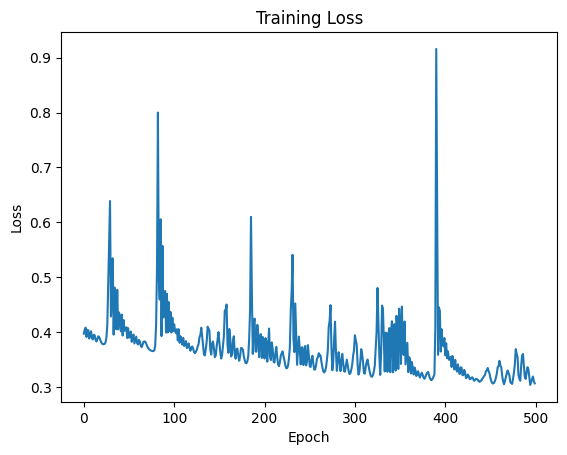

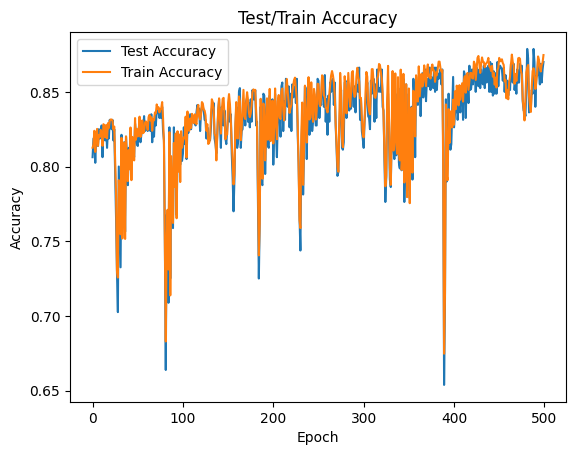

In [22]:
# Plot loss graph
plt.figure()
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot test/train accuracy graph
plt.figure()
plt.plot(test_accs, label='Test Accuracy')
plt.plot(train_accs, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test/Train Accuracy')
plt.legend()
plt.show()

Finally, the best epoch trained model is saved for future use:

In [23]:
torch.save(best_model_state, "models/detect_surface_feature_model_0.pt")

### 5.4 Model Validation
To validate the trained model, a new dataset is loaded and passed through the saved model. The accuracy of the model is then calculated based on the predictions made on the new data. The following code snippet demonstrates the model validation process:

In [24]:
saved_model = model
saved_model.load_state_dict(torch.load("models/detect_surface_feature_model_0.pt"))

saved_model = saved_model.to(device)
saved_model.eval()

GCN(
  (conv_layers): ModuleList(
    (0): GCNConv(3, 128)
    (1-3): 3 x GCNConv(128, 128)
    (4): GCNConv(128, 3)
  )
)

In [25]:
new_data = torch.load(dataset_validate_path)
new_data = new_data.to(device)
pred = saved_model(new_data).argmax(dim=1)
# predict correct with all nodes (not just test mask)
correct = (pred == new_data.y).sum()
acc = int(correct) / int(new_data.y.shape[0])

print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8431
